# Feature Engineering

For reference, I'm going to go into a bit more detail on the feature engineering. 
We will engineer features based on the human classification to find those features that predict the
observed properties of the light curves best.

There are two parts to feature engineering:
1. using cross validation to gauge what effect certain hyperparameters have on the final classification
2. comparing various features against each other and how effective they actually are in classification.

We'll do 1 first, then 2. 

## Setting Hyperparameters

If we restrict ourselves to summary statistics (rather than using 2D histograms of hardness ratios and/or 
full/binned periodograms), there are only a few hyperparameters left:

- the duration of a segment
- the overlap between consecutive segments
- the number of time bins used in the autoregressive model
- the time binning (if any) in the autoregressive model
- the regularization parameter in the autoregressive model
- the number of PCA bins in the power spectrum representation

We will incorporate all of this into a pipeline and cross-validate across a bunch 
of parameters to find out how well we can predict the (human-classified) data from
linear filter weights + a random forest alone.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import cPickle as pickle
from pandas.tools.plotting import scatter_matrix
import pandas as pd


import powerspectrum
import generaltools as gt
import feature_extraction
#import grs1915_utils

import glob
import scipy.stats

#import sys

#sys.path.append("/Users/danielahuppenkothen/work/repositories/LightEcho/code/")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap

import linearfilter

/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


First, let's load the data and split it into training, test and validation sets:

In [2]:
with open("../../grs1915_125ms_clean.dat", "r") as f:
    d_all = pickle.load(f)

    
## total number of light curves
n_lcs = len(d_all)

We're going to want to use some rebinning in conjunction with the autoregressive model to control for noise.

We need to define the rebinning of the light curve in a way that scikit-learn 
can parse, i.e. as a transformer class. This is kind of stupidly simple, but it'll come in handy.

In [3]:
class RebinTimeseries(BaseEstimator, TransformerMixin):

    def __init__(self, n=4, method="average"):

        """
        Initialize hyperparameters

        :param n: number of samples to bin
        :param method: "average" or "sum" the samples within a bin?
        :return:
        """

        self.n = n ## save number of bins to average together
        self.method = method

        return



    def fit(self,X):
        """
        I don't really need a fit method!
        """
        
        ## set number of light curves (L) and 
        ## number of samples per light curve (k)
        return self
        
        
    def transform(self, X):
        self.L, self.K = X.shape

    
        ## set the number of binned samples per light curve
        K_binned = int(self.K/self.n)
        
        ## if the number of samples in the original light curve
        ## is not divisible by n, then chop off the last few samples of 
        ## the light curve to make it divisible
        #print("X shape: " + str(X.shape))

        if K_binned*self.n < self.K:
            X = X[:,:self.n*K_binned]
        
        ## the array for the new, binned light curves
        X_binned = np.zeros((self.L, K_binned))
        
        if self.method in ["average", "mean"]:
            method = np.mean
        elif self.method == "sum":
            method = np.sum
        else:
            raise Exception("Method not recognized!")
        
        #print("X shape: " + str(X.shape))
        #print("L: " + str(self.L))
        for i in xrange(self.L):
            t_reshape = X[i,:].reshape((K_binned, self.n))
            X_binned[i,:] = method(t_reshape, axis=1)
        
        return X_binned


    def predict(self, X):
        pass
    
    def score(self, X):
        pass

    def fit_transform(self, X, y=None):

        self.fit(X)
        X_binned = self.transform(X)

        return X_binned



Next, we'll need to write a class that takes the data and makes features, in the same scikit-learn syntax:

In [4]:
import feature_extraction
import sys 

## boundaries for power bands
pcb = {"pa_min":0.0039, "pa_max":0.031,
       "pb_min":0.031, "pb_max":0.25,
       "pc_min":0.25, "pc_max":2.0,
       "pd_min":2.0, "pd_max":16.0}


class MakeFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, n=1, k=10, lamb=0.1, n_components=3):

        """
        Initialize hyperparameters

        Parameters
        ----------
        n : int
            The number of time steps in the light curve to rebin
            
        k : int
            number of samples to use in autoregressive model
            
        lamb : float
            the regularization parameter for the autoregressive model
            
        n_components : int
            number of components in the PCA decomposition
        
        """
        
        self.n = n
        self.k = k 
        self.lamb = lamb
        self.n_components = n_components

        return


    def fit(self,X):
        """
        I don't really need a fit method!
        """
        
        ## set number of light curves (L) and 
        ## number of samples per light curve (k)
        return self
        
        
    def transform(self, X):
        """
        transform time series into features.
        
        X should be a a matrix of dimension (N, L, J), where N is 
        the number of samples, L is the set of energy bins and J is 
        the number of time steps per light curve.
        
        """
        
        features = [] # empty list for features        
        
        # total counts in the light curve are stored in the second column for each 
        # sample
        #print("Extracting counts ...")
        counts = np.array([s[:,1] for s in X])

        #print("rebinning time series ...")
        rt = RebinTimeseries(n=self.n, method="average")
        counts_binned = rt.fit_transform(counts)
                
        #print("extracting weights from AR model ...")
        # weights of the autoregressive model
        ww = feature_extraction.linear_filter(counts_binned, k=self.k, lamb=self.lamb)

        #print("extracting PCA components from PSDs ...")
        # PCA on the power spectrum
        pca = feature_extraction.psd_pca(X, n_components=self.n_components)
        
        #print("extracting summary features ...")
        for s in X:

            features_temp = []

            ## time series summary features
            fmean, fmedian, fvar, fskew, fkurt = feature_extraction.timeseries_features(s)
            features_temp.extend([fmean, fmedian, np.log(fvar), fskew, fkurt])

            ## PSD summary features
            maxfreq, psd_a, psd_b, psd_c, psd_d, pc1, pc2 = feature_extraction.psd_features(s, pcb)
            
            if len(maxfreq) == 0:
                features_temp.extend([np.log(psd_a), np.log(psd_b), np.log(psd_c), np.log(psd_d), 
                                      np.log(pc1), np.log(pc2)])
            else:
                features_temp.extend([np.log(maxfreq), np.log(psd_a), np.log(psd_b), 
                                      np.log(psd_c), np.log(psd_d), np.log(pc1), np.log(pc2)])

            mu1, mu2, cov, skew, kurt = feature_extraction.hr_fitting(s)
            features_temp.extend([mu1, mu2])
            features_temp.extend([np.log(cov[0]), cov[1], np.log(cov[3])])
            features_temp.extend(list(skew))
            features_temp.extend(list(kurt))

            features.append(features_temp)

        features_all = np.hstack((np.array(features), np.array(ww)))
        features_all = np.hstack((np.array(features_all), np.array(pca)))
        
        return features_all


    def predict(self, X):
        pass
    
    def score(self, X):
        pass

    def fit_transform(self, X, y=None):
        
        self.fit(X)
        features = self.transform(X)
        return features



Before we start, we need to extract segments and give each a group label:

Let's split the data set into train, test and validation sets:

In [5]:
d_all_train, d_all_val, d_all_test = feature_extraction.split_dataset(d_all, 
                                                                      train_frac = 0.6, 
                                                                      validation_frac = 0.2, 
                                                                      test_frac = 0.2, seed=20160615)

There are 566 light curves in the validation set.
There are 566 light curves in the test set.
The number of states in the training set is 17
The number of states in the test set is 17
The number of states in the validation set is 17
These is the distribution of states in the training set: 
chi1      56
chi2      36
rho       31
kappa     28
chi4      28
delta     28
theta     26
beta      25
gamma     19
phi       14
chi3       8
nu         8
mu         8
lambda     6
alpha      5
eta        5
omega      3
dtype: int64
These is the distribution of states in the validation set: 
chi1      26
chi2      15
rho       13
theta     12
gamma     11
chi4      10
nu         7
delta      7
beta       7
mu         6
kappa      5
alpha      4
phi        4
eta        2
omega      1
chi3       1
lambda     1
dtype: int64
These is the distribution of states in the test set: 
chi1      18
chi2      17
theta     10
chi4       9
rho        9
beta       7
phi        6
gamma      6
kappa      5
delta     

Now we can extract segments of equal length for all three sets:

In [6]:
seg_length = 1024.
overlap = 256.
dt = 0.125

segments_train, labels_train, nsegments_train = feature_extraction.extract_segments(d_all_train, 
                                                                                    seg_length=seg_length, 
                                                                                    overlap=overlap, 
                                                                                    dt=dt)

segments_test, labels_test, nsegments_test = feature_extraction.extract_segments(d_all_test, 
                                                                                 seg_length=seg_length, 
                                                                                 overlap=overlap, 
                                                                                 dt=dt)

segments_val, labels_val, nsegments_val = feature_extraction.extract_segments(d_all_val, 
                                                                              seg_length=seg_length, 
                                                                              overlap=overlap, 
                                                                              dt=dt)


feature_extraction.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtemp = data[istart:iend]


In [7]:
label_mask_train = labels_train != "None"
label_mask_val= labels_val != "None"
label_mask_test = labels_test != "None"

In [8]:
segments_train_labelled = np.array(segments_train)[label_mask_train]
labels_train_labelled = labels_train[label_mask_train]
nsegments_train_labelled = nsegments_train[label_mask_train]

segments_test_labelled = np.array(segments_test)[label_mask_test]
labels_test_labelled = labels_test[label_mask_test]
nsegments_test_labelled = nsegments_test[label_mask_test]

segments_val_labelled = np.array(segments_val)[label_mask_val]
labels_val_labelled = labels_val[label_mask_val]
nsegments_val_labelled = nsegments_val[label_mask_val]

Let's test the individual components:

In [9]:
mf = MakeFeatures(n=1, k=7, lamb=100, n_components=3)
features = mf.fit_transform(np.vstack([segments_train_labelled, segments_val_labelled]), 
                            np.hstack([labels_train_labelled, labels_val_labelled]))
#f_val = mf.fit_transform(segments_val_labelled, labels_val_labelled) 

In [10]:
from sklearn.linear_model import LogisticRegression
## set the estimators to glue together:
lr = LogisticRegression(penalty="l2", class_weight=None, C=10.0,
                        solver="lbfgs")



In [11]:
lr.fit(features[:len(segments_train_labelled)], labels_train_labelled[:len(segments_train_labelled)])

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
lr.score(features[len(segments_train_labelled):,:], labels_val_labelled)

0.84210526315789469

Now, we can start building estimators for the cross-validation task. However, we need to make *all* features together, because we have to do the feature extraction on the whole data set.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LabelKFold

Below is a piece of example code running the cross-validation. We've only picked one set of parameters here, because everything else would take too long for a notebook. The corresponding code to run is in `parameter_estimation.py`.

In [14]:

## parameters to search using GridSearchCV
nn = [1.]#[1,4,8,80] ## number of samples to rebin
kk = [7]#[2,5,7,10,20] ## number of weights in the linear filter
lamb = [100]#[1.0, 10.,100., 1000. ] ## regularization parameter for ridge regression
n_components = [3]#[1, 2, 3, 5, 10, 20]
cc = [0.001, 0.01, 0.1, 1., 10. 40., 100., 1000.0]

# folds to use in cross-validation
n_folds = 5

# empty lists for validation scores
all_scores = []

# stack all segments together
seg_all_labelled = np.concatenate([segments_train_labelled, segments_val_labelled, segments_test_labelled])
# stack all segment indices together
nseg_all_labelled = np.hstack([nsegments_train_labelled, nsegments_val_labelled, nsegments_test_labelled])

# store number of samples in each set, for use below
ntrain = len(segments_train_labelled)
nval = len(segments_val_labelled)
ntest = len(segments_test_labelled)

# loop over all parameters
for i, n in enumerate(nn):
    for j, k in enumerate(kk):
        for l, lm in enumerate(lamb):
            for m, nc in enumerate(n_components):
                # make features using whole feature set
                # don't need to repeat this for each iteration of finding 
                # the regularization parameter for the logistic regression estimator
                mf = MakeFeatures(n=n, k=k, lamb=lm, n_components=nc)
                features = mf.fit_transform(seg_all_labelled)

                pars = {"n":n, "k":k, "lamb":lm, "n_components":nc}

                # make the GroupKFold cross validation generator
                group_kfold = LabelKFold(nsegments_train_labelled, n_folds=n_folds)

                # make a LogisticRegression object
                lr = LogisticRegression(penalty="l2", class_weight=None, 
                                        solver="lbfgs")

                # instantiate the GridSearchCV object for searching over regularization parameters
                grid_lr = GridSearchCV(lr, dict(C=cc), cv=group_kfold, verbose=3, n_jobs=1,
                                         scoring="f1_macro")
                # do grid search
                grid_lr.fit(features[:ntrain], labels_train_labelled)

                val_score = grid_lr.score(features[ntrain:ntrain+nval], labels_val_labelled)

                score_dict = {"train_scores": grid_lr.grid_scores_, "val_score":val_score, "pars":pars}

                all_scores.append(score_dict)

SyntaxError: invalid syntax (<ipython-input-14-d01240961391>, line 7)

In [ ]:
all_scores

Let's get out the validation scores:

In [ ]:
val_scores = np.array([s["val_score"] for s in all_scores])

And here's an array of the mean cross validation scores:

In [ ]:
mean_scores = [[m.mean_validation_score for m in s["train_scores"]] for s in all_scores]

We've done this using `parameter_estimation.py`, so we can now load the results:

In [40]:
with open("../../grs1915_best_estimator.dat", "r") as f:
    all_scores = pickle.load(f)

In [41]:
all_scores = np.array(all_scores)

In [42]:
all_scores[:2]

array([ {'train_scores': [mean: 0.27209, std: 0.07768, params: {'C': 0.001}, mean: 0.29219, std: 0.09090, params: {'C': 0.01}, mean: 0.31579, std: 0.08484, params: {'C': 0.1}, mean: 0.28240, std: 0.06077, params: {'C': 1.0}, mean: 0.26143, std: 0.08122, params: {'C': 10.0}, mean: 0.27879, std: 0.12159, params: {'C': 100.0}, mean: 0.27929, std: 0.11816, params: {'C': 1000.0}], 'pars': {'lamb': 1.0, 'k': 2, 'n_components': 1, 'n': 1}, 'val_score': 0.25138245421177091},
       {'train_scores': [mean: 0.31068, std: 0.12918, params: {'C': 0.001}, mean: 0.29475, std: 0.05967, params: {'C': 0.01}, mean: 0.32149, std: 0.07394, params: {'C': 0.1}, mean: 0.27877, std: 0.08493, params: {'C': 1.0}, mean: 0.26896, std: 0.07110, params: {'C': 10.0}, mean: 0.26492, std: 0.07467, params: {'C': 100.0}, mean: 0.26366, std: 0.06606, params: {'C': 1000.0}], 'pars': {'lamb': 1.0, 'k': 2, 'n_components': 2, 'n': 1}, 'val_score': 0.38123480767778245}], dtype=object)

In [43]:
val_scores = np.array([s["val_score"] for s in all_scores])

In [44]:
val_max_ind = np.where(val_scores == np.max(val_scores))[0]

In [45]:
max_set = all_scores[val_max_ind]

In [46]:
max_set

array([ {'train_scores': [mean: 0.29892, std: 0.07070, params: {'C': 0.001}, mean: 0.40702, std: 0.14274, params: {'C': 0.01}, mean: 0.40240, std: 0.07367, params: {'C': 0.1}, mean: 0.33244, std: 0.12174, params: {'C': 1.0}, mean: 0.35095, std: 0.09974, params: {'C': 10.0}, mean: 0.36771, std: 0.08344, params: {'C': 100.0}, mean: 0.33793, std: 0.10751, params: {'C': 1000.0}], 'pars': {'lamb': 1000.0, 'k': 10, 'n_components': 10, 'n': 1}, 'val_score': 0.48089980748228928}], dtype=object)

In [47]:
mean_scores = np.array([[m.mean_validation_score for m in s["train_scores"]] for s in all_scores])

In [48]:
np.max(mean_scores)

0.43039571497742818

In [49]:
max_ind = np.where(mean_scores == np.max(mean_scores))[0]

In [50]:
mean_scores[max_ind]

array([[ 0.35929676,  0.30263375,  0.37591296,  0.43039571,  0.39724662,
         0.38577056,  0.39399234]])

In [51]:
cv_max_scores = all_scores[max_ind]

In [52]:
cv_max_scores

array([ {'train_scores': [mean: 0.35930, std: 0.07795, params: {'C': 0.001}, mean: 0.30263, std: 0.06860, params: {'C': 0.01}, mean: 0.37591, std: 0.10152, params: {'C': 0.1}, mean: 0.43040, std: 0.10592, params: {'C': 1.0}, mean: 0.39725, std: 0.09884, params: {'C': 10.0}, mean: 0.38577, std: 0.09161, params: {'C': 100.0}, mean: 0.39399, std: 0.05600, params: {'C': 1000.0}], 'pars': {'lamb': 10000.0, 'k': 50, 'n_components': 50, 'n': 1}, 'val_score': 0.33584502740205424}], dtype=object)

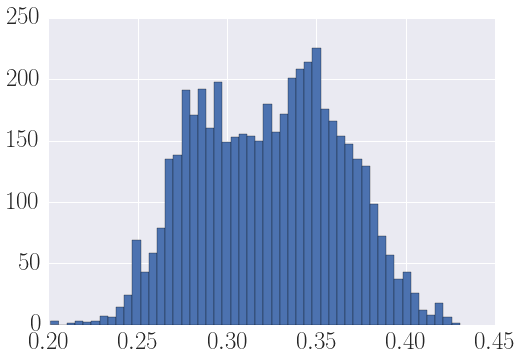

In [53]:
plt.hist(mean_scores.flatten(), bins=50);

We find the best validation score for a model with 
    - $k = 10$ for the linear model
    - $\lambda = 1000$ for the regularization of the linear model
    - $n = 1$, i.e. no binning of the light curves
    - $n_{\mathrm{components}} = 10$, i.e. only one of the PCA components
    - $C = 1.0$
    
We can now use this information to extract features. 
We will extract summary statistics for segments of 1024s and 256s duration as 
well as the weights of a linear model as features. 

In [54]:
datadir="../../"
seg_length_supervised =1024.0
seg_length_unsupervised =1024.0
overlap_all = 256.

k = 10
lamb = 1000 
n = 1
n_components= 10


In [76]:
with open("../../grs1915_125ms_clean.dat", "r") as f:
    d_all = pickle.load(f)

In [55]:
reload(feature_extraction)
feature_extraction.extract_all(d_all, seg_length_all=[1024.], overlap=[256.],
                               val=True, train_frac=0.5, validation_frac = 0.25, test_frac = 0.25,
                               k=k, lamb=lamb, n_components=n_components,
                               datadir="../../", seed=20160615)

The number of states in the training set is 17
The number of states in the test set is 17
The number of states in the validation set is 17
Checking for NaN in the training set ...
4669 samples in training data set before checking for NaNs.
2450 samples in test data set before checking for NaNs.
Checking for NaN in the test set ...
4669 samples in training data set after checking for NaNs.
2450 samples in test data set before after for NaNs.
Checking for NaN in the validation set ...
2094 samples in validation data set after checking for NaNs.


In [79]:
import feature_engineering

In [80]:
features, labels, lc, hr, tstart = feature_engineering.load_features(datadir, 1024.)

Found outlier in validation set
after removal: []


In [82]:
features["test"].shape

(2349, 51)

Now we can use our feature vector to actually determine what the *most descriptive* features are. 

## Finding the most descriptive features
I'm going to start with all of the summary features and use a greedy approach: out of all summary features, which is the one that alone predicts the human classification best? I am going to keep that, and then add a second feaure, again going through the entire list of left-over features to figure out the best combination of two, and so on, until I reach the end of the 13 features. 

In the second step, I can add feature sets like the entire heatmap of the hardness diagram, or the periodogram to the game, but we'll keep it simple(ish) with the summary features only for now.

For this task, I'm going to use Random Forests, because I have to pick an algorithm and this one seems to be pretty robust.

In [ ]:
datadir= "../../"
seg_length_supervised = 1024.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_supervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_supervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_supervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_supervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_supervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_supervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)

features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]


In [ ]:
print("There are %i training samples with %i features"%features_train.shape)
print("There are %i validation samples with %i features"%features_val.shape)
print("There are %i test samples with %i features"%features_test.shape)


The features here are:
* mean count rate
* median count rate
* total variance in the count rate
* skew of the countrate
* kurtosis of the count rate
* Frequency where the PSD has its maximum
* Power Spectral Band A
* Power Spectral Band B
* Power Spectral Band C
* Power Spectral Band D
* Power Spectral Color 1 (PSDc/PSDa)
* Power Spectral Color 2 (PSDb/PSDd)
* mean of hardness ratio HR1
* mean of hardness ratio HR2
* flattened covariance matrix of HR1 and HR2
* skew of HR1 and HR2
* kurtosis of HR1 and HR2
* 10 weights from the linear filter
* 10 PCA components decomposing the power spectrum

for a total of 31 features.

In [ ]:

score = []
best_params = []
## first feature
for i in range(features_train.shape[1]):
    ft = np.atleast_2d(features_train[:,i]).T
    fv = np.atleast_2d(features_val[:,i]).T

    ### scale features
    scaler_train = StandardScaler().fit(ft)
    fscaled_train = scaler_train.transform(ft)
    #print(fscaled_train.shape)
    
    scaler_val = StandardScaler().fit(fv)
    fscaled_val = scaler_val.transform(fv)
    
    ### Random Forest Classifier
    params = {'max_depth': [5,6,7,10,12,15,20,50,100,200]}#,
    grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=300), param_grid=params,
                            verbose=0, n_jobs=10)

    grid_rfc.fit(fscaled_train, labels_train)
    print("Best results for the Random Forest run:")
    print("Best parameter: " + str(grid_rfc.best_params_))
    best_params.append(grid_rfc.best_params_)
    print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
    print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
    score.append(grid_rfc.score(fscaled_val, labels_val))


In [ ]:
max_ind = np.where(score == np.max(score))[0]
max_score = score[max_ind]
print("The maximum validation score of %.3f was achieved for feature %i"%(max_score, max_ind))

It looks like on the first try, the frequency where the PSD has its maximum does best in predicting the human classification on the validation set. Let's now automate this process for the rest of the features.

In [ ]:
score_all = []
feature_ranking = []
nfeatures = range(features_train.shape[1])
features_new_train = []
features_new_val = []
features_new_test = []
best_params_all = []

for i in range(features_train.shape[1]):
    print("I am on the %ith loop"%i)
    score = []
    best_params = []
    ## first feature
    for j in nfeatures:
        if j in feature_ranking:
            continue
        #print("I am on feature %i"%j)
        if len(features_new_train) == 0:
            ft = np.atleast_2d(features_train[:,j]).T
            fv = np.atleast_2d(features_val[:,j]).T
            fte = np.atleast_2d(features_test[:,j]).T
        else:
            ft = np.concatenate((features_new_train, ft), 1)
            fv = np.concatenate((features_new_val, fv), 1)
            fte = np.concatenate((features_new_test, fte), 1)
        ### scale features
        f_all = np.concatenate((ft, fv, fte))
        #print("NaN in row: " + str(np.where(np.isnan(f_all))))
        scaler_train = StandardScaler().fit(f_all)
        fscaled_train = scaler_train.transform(ft)
        
        fscaled_val = scaler_train.transform(fv)
        ### Random Forest Classifier
        params = {'max_depth': [5,10,20,50,100,200,400]}#,
        grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=250), param_grid=params,
                                verbose=0, n_jobs=15)
        grid_rfc.fit(fscaled_train, labels_train)
        best_params.append(grid_rfc.best_params_)
        score.append(grid_rfc.score(fscaled_val, labels_val))
    
    score_all.append(score)
    best_params_all.append(best_params)
    best_ind = np.where(score == np.max(score))[0]
    print("best_ind: " + str(best_ind))
    if len(best_ind) > 1:
        best_ind = best_ind[0]
    print("The best score in round " + str(i) + " is " + str(np.max(score)))
    n_best = nfeatures.pop(best_ind)
    print("The best-ranked feature in round " + str(i) + " is " + str(n_best))
    feature_ranking.append(n_best)
    if len(features_new_train) == 0:
        features_new_train = np.atleast_2d(features_train[:,n_best]).T
        features_new_val = np.atleast_2d(features_val[:,n_best]).T
        features_new_test = np.atleast_2d(features_test[:,n_best]).T
    else:
        features_new_train = np.concatenate((features_new_train, np.atleast_2d(features_train[:,n_best]).T), 1)
        features_new_val = np.concatenate((features_new_val, np.atleast_2d(features_val[:,n_best]).T), 1)
        features_new_test = np.concatenate((features_new_test, np.atleast_2d(features_test[:,n_best]).T), 1)


In [56]:
## Print the indices of the original feature vector by importance
print(feature_ranking)

NameError: name 'feature_ranking' is not defined


In detail, the ranking of the feature gives: 

0. Power Spectral Colour 1
1. variance of HR 1
2. Power Spectral Band C
3. median count rate
4. one of the linear filter weights
5. one of the linear filter weights
6. Power Spectral Band D
7. Power Spectral Band B
8. kurtosis of the count rate
9. one of the linear filter weights
10. one of the linear filter weights
11. Power spectral colour 2
12. kurtosis of HR 2
13. total variance in the light curve
14. covariance between HR1 and HR2
15. Frequency where the PSD has its maximum
16. mean of HR1
17. one of the linear filter weights
18. skew of HR2
19. mean count rate
20. one of the linear filter weights
21. one of the linear filter weights
22. Power Spectral Band A
23. kurtosis of HR1 
24. skew of the count rate
25. one of the linear filter weights
26. skew of HR1
27. mean of HR 2
28. one of the linear filter weights
29. one of the linear filter weights
30. variance of HR 1

There's a mix of all features (hardness ratios, power spectral, overall time series) here, which means that all components seem to be fairly important to the classification. The linear filter does pretty well, and most of the top ten features are related to the time series and the PSD. 


In [ ]:
# Find the maximum of the validation scores for each run.
score_max_all = np.array([np.max(s) for s in score_all])
print(score_max_all)

We can plot the curve of the validation accuracy versus the number of features to get some picture of how much the different features add to the overall classification.

In [ ]:
## plot the validation fraction versus the number of features in the classification
plt.plot(np.arange(len(score_max_all))+1., score_max_all, "o-")
plt.xlabel("Number of features")
plt.ylabel("Validation accuracy")

The validation fraction seems to saturate at about 80%.

It's not clear whether this means
- there's too little data
- the human classification just sucks
- the features don't accurately encapsulate the various behaviours in the data (e.g. QPOs)

Let's print a confusion matrix for the run (1) with all features (2) with only 20 features and (3) with only 6 features.


In [ ]:
best_params_all[-1]

In [ ]:
nfeatures = [6, 20, 31]

for n in nfeatures:
    features_new_red = np.concatenate((features_new_train[:,:n], features_new_val[:,:n], features_new_test[:,:n]))

    scaler_train = StandardScaler().fit(features_new_red)
    fscaled_train = scaler_train.transform(features_new_train[:,:n])
    fscaled_val = scaler_train.transform(features_new_val[:,:n])
    fscaled_test = scaler_train.transform(features_new_test[:,:n])

    rfc_red = RandomForestClassifier(n_estimators=500, max_depth=400)
    rfc_red.fit(fscaled_train, labels_train)
    print("Training accuracy: " + str(rfc_red.score(fscaled_train, labels_train)))
    print("Validation accuracy: " + str(rfc_red.score(fscaled_val, labels_val)))

    labels_rfc_red = rfc_red.predict(fscaled_val)

    fig = plt.figure(figsize=(15,15))

    sns.set_style("white") 
    unique_labels = np.unique(labels_test)
    cm = confusion_matrix(labels_val, labels_rfc_red, labels=unique_labels)
    cm = cm.astype(np.float64)
    cm /= np.max(cm, axis=1)
    print(type(cm))
    print(cm)
    
    #print(unique_labels)
    ax1 = fig.add_subplot(121)
    ax1.matshow(cm, cmap=cmap.Spectral_r )
    ax1.set_title('Confusion matrix, %i features'%n)
    #plt.colorbar()
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
    plt.yticks(range(len(unique_labels)), unique_labels)
    #plt.show()



It seems like there are no significant differences between the latter two, but there are between the run with 6 features and that with 20. For some classes, the 6 feature classifcation actually seems to do better, but this is likely due to overfitting when using many features.

It seems like 20 is a good choice for the number of features. We can also print out the relative feature importances as derived from the Random Forest:



In [ ]:
features_new_full = np.concatenate((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(features_new_red)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)

rfc_full = RandomForestClassifier(n_estimators=500, max_depth=400)
rfc_full.fit(fscaled_train, labels_train)

imp_rfc_full = rfc_full.feature_importances_

std_full = np.std([tree.feature_importances_ for tree in rfc_full.estimators_],
             axis=0)

indices_full = np.argsort(imp_rfc_full)[::-1]

# Print the feature ranking for the full feature vector
print("Feature ranking, full feature vector:")

for f in range(31):
    print("%d. feature %d (%f)" % (f + 1, indices_full[f], imp_rfc_full[indices_full[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importances")
plt.bar(range(31), imp_rfc_full[indices_full],
       color="r", yerr=std_full[indices_full], align="center")
plt.xticks(range(31), indices_full)
plt.xlim([-1, 32])
plt.show()




The feature importances derived from the trees isn't quite the same as from the greedy search. Note, however, that the inter-tree variability is fairly large, indicating that all of the features may contribute significantly to the classification.

The top 5 features for the full feature set:
1. mean count rate in the full light curve
2. one of the linear filter weights
3. mean of HR 2
4. variance of HR 2
5. Power Spectral Band A


## Does Adding Many features help?

tl;dr: **No**.

There are two alternatives that would extend the features above. One is including either the full heat map of the hardness ratios, or the full periodogram. Perhaps we could use some clever dimensionality reduction on either of those to make the problem more clever. For now, I am simply going to test whether adding either the full periodogram or the HR heat maps will aid the classification task (hint: I don't think so!).

We'll start with the heat maps of hardness ratios. These are basically HR1 and HR2 for each light curve combined in a 2D histogram with 20 by 20 bins with the same ranges in both dimensions for each light curve.


In [ ]:
f = open(datadir+"grs1915_1024_clean_hrfull_features.dat", "r")
feature_dict = pickle.load(f)
f.close()

features_train = np.array(feature_dict["train"][0]["features"])
features_val = np.array(feature_dict["val"][0][0]["features"])
features_test = np.array(feature_dict["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = feature_dict["train"][1]
labels_val = feature_dict["val"][0][1]
labels_test = feature_dict["test"][1]

In [ ]:
f_all = np.concatenate((features_train, features_val, features_test))
scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train)
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))


The validation accuracy of this model is actually *lower* than just using the summaries. Rubbish! This is clearly not the answer. What about using the full periodogram?

In [ ]:
f = open(datadir+"grs1915_1024_clean_psfull_features.dat", "r")
feature_dict = pickle.load(f)
f.close()

features_train = np.array(feature_dict["train"][0]["features"])
features_val = np.array(feature_dict["val"][0][0]["features"])
features_test = np.array(feature_dict["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = feature_dict["train"][1]
labels_val = feature_dict["val"][0][1]
labels_test = feature_dict["test"][1]

In [ ]:
f_all = np.concatenate((features_train, features_val, features_test))
scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train)
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))


The result including the whole periodogram isn't much better (given some variance in the validation and test accuracy due to the probabilistic nature of the Random Forest classifier). Either we'll need to be a lot smarter about making our features, or this is as good as it's going to get.

## How good is the computer compared to human classification?

Let's check how good the computer does compared to the human classification. For this purpose, we'll be making plots that show light curve, PSD and HR diagram for (1) the segment in question, (2) six examples of the human-classified class, (3) six examples of the computer-classified class.
These plots will be made for all misclsasified light curves, and serves as a sanity check of whether the computer is actually just misclassifying, or whether there are ambiguities in the human classification.


In [ ]:
lc_all_full = gt.getpickle(datadir+"grs1915_%is_lc_all.dat"%seg_length_supervised)
hr_all_full = gt.getpickle(datadir+"grs1915_%is_hr_all.dat"%seg_length_supervised)

lc_train_full = lc_all_full["train"]
lc_test_full = lc_all_full["test"]
lc_val_full = lc_all_full["val"]

hr_train_full = hr_all_full["train"]
hr_test_full = hr_all_full["test"]
hr_val_full = hr_all_full["val"]

train_ind = np.where(labels_train_full != "None")[0]
lc_train = np.array([lc_train_full[i] for i in train_ind])
hr_train = np.array([hr_train_full[i] for i in train_ind])

val_ind = np.where(labels_val_full != "None")[0]
lc_val = np.array([lc_val_full[i] for i in val_ind])
hr_val = np.array([hr_val_full[i] for i in val_ind])

test_ind = np.where(labels_test_full != "None")[0]
lc_test = np.array([lc_test_full[i] for i in test_ind])
hr_test = np.array([hr_test_full[i] for i in test_ind])


We'll need to reshuffle the feature vector to match the reduced one 

In [ ]:
print(feature_ranking)
nfeatures = 20 ## the number of features to use

Now let's do the classification one more time.

In [ ]:
f_all = np.concatenate((features_new_train[:,:nfeatures], features_new_val[:,:nfeatures], features_new_test[:,:nfeatures]))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train[:,:nfeatures])
fscaled_val = scaler_train.transform(features_val[:,:nfeatures])
fscaled_test = scaler_train.transform(features_test[:,:nfeatures])

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))

labels_rfc = grid_rfc.predict(fscaled_val)
labels_rfc_test = grid_rfc.predict(fscaled_test)


Now we can plot all light curves that are confused in the validation set:

In [ ]:
import powerspectrum
import copy
import scipy.stats

def plot_misclassifieds(features, trained_labels, real_labels, lc_all, hr_all, hr_limits,
                        nexamples=6, namestr="misclassified", datadir="./"):

    """
    Find all mis-classified light curves and plot them with examples of the real and false classes.
    """
    misclassifieds = []
    for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features, trained_labels, real_labels, lc_all, \
                                                hr_all)):
        if lpredict == ltrue:
            continue
        else:
            misclassifieds.append([f, lpredict, ltrue, lc, hr])

    for j,m in enumerate(misclassifieds):
        pos_human = np.random.choice([0,3], p=[0.5, 0.5])
        pos_robot = int(3. - pos_human)

        f = m[0]
        lpredict = m[1]
        ltrue = m[2]
        times = m[3][0]
        counts = m[3][1]
        hr1 = m[4][0]
        hr2 = m[4][1]
        print("Predicted class is: " + str(lpredict))
        print("Human classified class is: " + str(ltrue))
        robot_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lp == lpredict ]
        human_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lp == ltrue ]

        np.random.shuffle(robot_all)
        np.random.shuffle(human_all)
        robot_all = robot_all[:6]
        human_all = human_all[:6]

        sns.set_style("darkgrid")
        current_palette = sns.color_palette()
        fig = plt.figure(figsize=(10,15))

        def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
            #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
            ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
            ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([times[0], times[-1]])
            ax.set_ylim([0.0, 12000.0])
            #print("plotting in grid point " + str((xcoords[1], ycoords[1])))

            #h, xedges, yedges = np.histogram2d(np.log(hr1), np.log(hr2), bins=40, 
            #                       range=hr_limits)
            #h = np.rot90(h)
            #h = np.flipud(h)

            #hmax = np.max(h)
            #print(hmax)
            #hmask = np.where(h > hmax/20.)
            #hmask1 = np.where(h < hmax/20.)

            #hnew = copy.copy(h)
            #hnew[hmask[0], hmask[1]] = 1.
            #hnew[hmask1[0], hmask1[1]] = 0.0

            #ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            #ax.pcolormesh(xedges,yedges,hnew,cmap='BuPu')
            #ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            #ax.set_xlim(hr_limits[0])
            #ax.set_ylim(hr_limits[1])

            ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            ax.set_xlim([.27, 0.85])
            ax.set_ylim([0.04, 0.7])

            #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
            ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
            dt = np.min(np.diff(times))
            ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
            ps.freq = np.array(ps.freq)
            ps.ps = np.array(ps.ps)*ps.freq
            
            binfreq = np.logspace(np.log10(ps.freq[1]), np.log10(ps.freq[-1]), 24)
            binps, bin_edges, binno = scipy.stats.binned_statistic(ps.freq[1:], ps.ps[1:], statistic="mean", bins=binfreq)

            df = binfreq[1:]-binfreq[:-1]
            binfreq = binfreq[:-1]+df/2.
            ax.loglog(binfreq[1:], binps[1:], linestyle="steps-mid", rasterized=True)
            ax.set_xlim([ps.freq[1], ps.freq[-1]])
            ax.set_ylim([1.e-6, 10.])

            return

        ## first plot misclassified:
        plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)

        ## now plot examples
        for i in range(4):
            r = robot_all[i]
            h = human_all[i]
            #print(h[0])
            #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
            #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
            plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
            plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)

        ax = plt.subplot2grid((9,6),(8,pos_human+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
        ax = plt.subplot2grid((9,6),(8,pos_robot+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
        #plt.show()
        plt.savefig(datadir+"misclassified%i.pdf"%j, format="pdf")
        plt.close()

In [ ]:
hr2_min = -3.0
hr2_max = 2.0
hr1_min = -2.5
hr1_max = 1.5

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 14})
plt.rc("font", size=14, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=14, labelsize=14) 
plt.rc("text", usetex=True)


plot_misclassifieds(features_new_val[:,:nfeatures], labels_rfc_red, labels_val, lc_val, hr_val, 
                    [[hr1_min, hr1_max],[hr2_min, hr2_max]],
                    nexamples=6, namestr="misclassified", datadir="../../")

## Classifying All Light Curves

Based on the (imperfect) supervised learning, let's classify *all* light curves, even the ones where there is no human classification. 

Because we don't want to have to run the expensive greedy search every time, we'll use the feature ranking from the previous run, reshuffle and concatenate the feature vector such that it looks like the one we want to use for various purposes later.


In [ ]:
feature_ranking = [10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 20, 
                   2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 3, 23, 
                   17, 13, 29, 21, 14]

We're going to need to use the data that has the *unclassified* data in it, at least for the scaling.

In [ ]:
## we'll be using the first 20 re-ranked features
max_features = 20

## make new empty arrays for the ranked features
features_new_train = np.zeros_like(features_train_full[:,:max_features])
features_new_val = np.zeros_like(features_val_full[:,:max_features])
features_new_test = np.zeros_like(features_test_full[:,:max_features])

for i,f in enumerate(feature_ranking[:max_features]):
    features_new_train[:,i] = features_train_full[:,f]
    features_new_val[:,i] = features_val_full[:,f]
    features_new_test[:,i] = features_test_full[:,f]


Now let's scale all features:

In [ ]:
f_all = np.vstack((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)



Now we'll need to split out those features with human classifications versus those without.

In [ ]:
## human-classified features
fscaled_train_human = fscaled_train[np.where(labels_train_full != "None")]
fscaled_val_human = fscaled_val[np.where(labels_val_full != "None")]
fscaled_test_human = fscaled_test[np.where(labels_test_full != "None")]

## human classified labels
labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]

## unclassified features
fscaled_train_unclass = fscaled_train[np.where(labels_train_full == "None")]
fscaled_val_unclass = fscaled_val[np.where(labels_val_full == "None")]
fscaled_test_unclass = fscaled_test[np.where(labels_test_full == "None")]

## combine unclassified features
fscaled_all_unclass = np.vstack((fscaled_train_unclass, fscaled_val_unclass, fscaled_test_unclass))



Next, let's do the supervised classification one last time. 

In [ ]:
#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train_human, labels_train)

print("Training accuracy: " + str(grid_rfc.score(fscaled_train_human, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val_human, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test_human, labels_test)))

labels_rfc = grid_rfc.predict(fscaled_val_human)
labels_rfc_test = grid_rfc.predict(fscaled_test_human)


In [ ]:
labels_rfc_unclass = grid_rfc.predict(fscaled_all_unclass)

So now that we've predicted labels for all unclassified segments, let's see what they look like.

### Looking at a 2D representation of the features

t-SNE provides a cool visualization of high-dimensional data spaces. We will take the 20 features and learn that representation for *all* segments at the same time. Do not do this at home unless you have a machine with lots of memory, or it'll crash!

In [ ]:
tsne = gt.getpickle(datadir+"grs1915_%i_tsne.dat"%seg_length_supervised)
asdf = gt.getpickle(datadir+"grs1915_%i_tsne_projected.dat"%seg_length_supervised)

In [ ]:
labels_all = np.hstack((labels_train, labels_val, labels_test, labels_rfc_unclass))

label_set = np.unique(labels_all)
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])



In [ ]:
fig = plt.figure(figsize=(11,9))
gs = gridspec.GridSpec(1, 5)

## background is white
sns.set_style("white")
ax = plt.subplot(gs[:,:])
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## this is the actual scatter plot
sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})
sns.set_style("darkgrid")
plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

ax1 = plt.subplot(gs[0,:4])

## loop over all labels, make a scatter plot
colors = ["grey"]
colors.extend(np.loadtxt("colors.txt"))
for k, col in zip(range(nlabels), colors):
    
    my_members = labels_numeric == k
    ax1.plot(asdf[my_members, 0], asdf[my_members, 1],".", color=col)

    
    
### Now make a legend on the side of the plot
lines = []
# background of the legend is white
sns.set_style("white")
ax2 = plt.subplot(gs[0,4])
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## for each label, make a non-existent line
for i,l in enumerate(label_set):
    line = mlines.Line2D([], [], color=colors[i], marker='o',
                          markersize=9, label=l, linewidth=0, zorder=10)
    lines.append(line)

## now actually make the axis
ax2.legend(handles=lines, loc='upper left', shadow=True)

### labels for the entire plot
ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_%i_tsne.pdf"%seg_length_unsupervised, format="pdf")    
    



### The overall distribution of states

Let's plot the number of segments in which the source was in any given state:

In [ ]:
import pandas as pd

labels_all = np.hstack((labels_train, labels_val, labels_test, labels_rfc_unclass))

label_set = np.unique(labels_all)
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])

s = pd.Series(labels_all)

In [ ]:
labels_all.dtype

In [ ]:
nstates = s.value_counts()

In [ ]:
nstates.plot(kind='bar')
plt.title("Distribution of classified states from the supervised classification", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Number of 1024-second segments in state", fontsize=15)
plt.savefig(datadir+"grs1915_allclasses_supervised.pdf", format="pdf")
#plt.close()


We can translate that into seconds spent in a given state:

In [ ]:
nstates = s.value_counts()
print(nstates.values)
nstates *= 1024.0
print(nstates.values)

In [ ]:
nstates = s.value_counts()
print(nstates.values)
nstates *= 1024.0
print(nstates.values)

nstates.plot(kind='bar')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title("Distribution of  states from the supervised classification", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Number of 1024-second segments in state", fontsize=15)
plt.savefig(datadir+"grs1915_allclasses_supervised_seconds.pdf", format="pdf")
#plt.close()


### Distribution of states with time

We'd like to know how these states are distributed over the duration of the observations, that is, all 16 years. For that, we'll need the time stamps of each. 

In [ ]:
tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)

## human classified segments
tstart_train = tstart_train_full[np.where(labels_train_full != "None")]
tstart_test = tstart_test_full[np.where(labels_test_full != "None")]
tstart_val = tstart_val_full[np.where(labels_val_full != "None")]

## unclassified segments
tstart_train_unclass = tstart_train_full[np.where(labels_train_full == "None")]
tstart_val_unclass = tstart_val_full[np.where(labels_val_full == "None")]
tstart_test_unclass = tstart_test_full[np.where(labels_test_full == "None")]


tstart_all = np.hstack((tstart_train, tstart_val, tstart_test,
                       tstart_train_unclass, tstart_val_unclass, tstart_test_unclass))


mjdrefi = 49353. 
tstart_all /= (60*60*24.)
tstart_all += mjdrefi

Let's load the ASM data so we can compare the states to the long-term light curve:

In [ ]:
## load and plot ASM light curve
asm = np.loadtxt(datadir+"grs1915_asm_lc.txt",skiprows=5)

asm_time = asm[:,0]
asm_cr = asm[:,1]
asm_total = asm_time[-1]-asm_time[0]
print("The ASM light curve covers a total of %i days"%asm_total)



Now we can make the plot. This code looks fairly complicated, but that's mostly fluff to make it look pretty.

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len

fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(11, 5)

sns.set_style("white")

ax = plt.subplot(gs[:,:])
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("darkgrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

current_palette = sns.color_palette(n_colors=len(label_set))
colours = [current_palette[j] for j in labels_numeric]


i = 0
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    #ax1 = fig.add_subplot(11,1,i+1)
    ax1 = plt.subplot(gs[i, :4])

    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    path = ax1.scatter(tstart_all, np.ones(len(tstart_all))*240., facecolor=colours,
                edgecolor="None")
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    ax1.set_yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1


    
    
### HORRIBLY COMPLICATED WAY TO MAKE THE LEGEND    
lines = []

sns.set_style("white")
ax2 = plt.subplot(gs[:3,4])

# Turn off axis lines and ticks of the big subplot
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

for i,l in enumerate(label_set):
    line = mlines.Line2D([], [], color=current_palette[i], marker='o',
                          markersize=9, label=l, linewidth=0, zorder=10)
    lines.append(line)

ax2.legend(handles=lines, loc='upper left', shadow=True)

### LABELS
ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_asm_lc_all.pdf", format="pdf")
#plt.close()

### Transition Matrix between states

We also want a matrix of the transition probabilities: given that the source is in state $k$, what is the probability it will transition to state $i$?

First, we need to sort the labels by time:

In [ ]:
## stack labels and start times
time_labels = np.vstack((tstart_all, labels_numeric)) 

## sorted lists
tl_sorted = np.array(sorted(time_labels.T, key=lambda a_entry: a_entry[0]))

In [ ]:
## compute the difference between starting points of consecutive 
## segments in seconds
dt = np.diff((tl_sorted[:,0]-mjdrefi)*(60*60.*24.))

## find all indices where segments are more than 1024 seconds apart
breakind = np.where(dt > seg_length_supervised)[0]

sorted_times = tl_sorted[:,0]
sorted_states = tl_sorted[:,1]

sorted_states_new = [sorted_states[:breakind[0]]]
for i in xrange(len(breakind[:-1])):
    sorted_states_new.append(sorted_states[breakind[i]:breakind[i+1]])
                
    


Now we can compute the transition matrix.

**NOTE**: I should put in some handler for breaks between consecutive light curves that are longer than the duration of the light curve, because I don't know what the state was in between those!

In [ ]:
from collections import Counter


## number of unique states
label_set = np.unique(sorted_states)
nlabels = len(label_set)


b_all = []
for s in sorted_states_new:
    b = np.zeros((nlabels,nlabels))

    for (x,y), c in Counter(zip(s, s[1:])).iteritems():
        b[x-1,y-1] = c

    b_all.append(b)



In [ ]:
b_all = np.array(b_all)
b = np.sum(b_all, axis=0)

## normalize to make each row sum up to 1
b = np.array([x/xsum for x,xsum in zip(b,np.sum(b, axis=1))])
#b /= np.sum(b, axis=0)

plt.matshow(b, cmap=cmap.Spectral_r)

## How Gaussian are my features?

For a given class, I want to know how Gaussian my features are, because in the unsupervised part of the project, we're going to use a Gaussian Mixture Model (GMM) to specify the distribution of features into states. We're going to do that for the feature set that we have labels for only.

So, for each state, we're now going to make histograms for each feature in order to gauge its Gaussianity. Double-peaked distributions are okay (these might separate out into separate states, or can be modeled by mixtures), but long-tailed distributions would be bad. 


Also, in the unsupervised learning, we'll be using the shorter segments, so let's look at those features.

In [ ]:
datadir= "../../"
seg_length_unsupervised = 256.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_unsupervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_unsupervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_unsupervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_unsupervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_unsupervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_unsupervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_unsupervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_unsupervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_unsupervised)

feature_ranking = [10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 
                   20, 2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 
                   3, 23, 17, 13, 29, 21, 14]

## we'll be using the first 20 re-ranked features
max_features = 20

## make new empty arrays for the ranked features
features_new_train = np.zeros_like(features_train_full[:,:max_features])
features_new_val = np.zeros_like(features_val_full[:,:max_features])
features_new_test = np.zeros_like(features_test_full[:,:max_features])

for i,f in enumerate(feature_ranking[:max_features]):
    if i in [0,2,3,6,7,11,13,15,16,19,20]:
        print("Making a log of parameter %i"%i)
        features_new_train[:,i] = np.log(features_train_full[:,f])
        features_new_val[:,i] = np.log(features_val_full[:,f])
        features_new_test[:,i] = np.log(features_test_full[:,f])
    else:
        features_new_train[:,i] = features_train_full[:,f]
        features_new_val[:,i] = features_val_full[:,f]
        features_new_test[:,i] = features_test_full[:,f]


In [ ]:
f_all = np.vstack((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)


fscaled_train_human = fscaled_train[np.where(labels_train_full != "None")]
fscaled_val_human= fscaled_val[np.where(labels_val_full != "None")]
fscaled_test_human = fscaled_test[np.where(labels_test_full != "None")]

fscaled_train_unclass = fscaled_train[np.where(labels_train_full == "None")]
fscaled_val_unclass = fscaled_val[np.where(labels_val_full == "None")]
fscaled_test_unclass = fscaled_test[np.where(labels_test_full == "None")]

fscaled_all_human = np.vstack((fscaled_train_human, fscaled_val_human, fscaled_test_human))
fscaled_all_unclass = np.vstack((fscaled_train_unclass, fscaled_val_unclass, fscaled_test_unclass))
fscaled_all = np.vstack((fscaled_all_human, fscaled_all_unclass))

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]

labels_train_unclass = labels_train_full[np.where(labels_train_full == "None")]
labels_val_unclass = labels_val_full[np.where(labels_val_full == "None")]
labels_test_unclass = labels_test_full[np.where(labels_test_full == "None")]

labels_all_human = np.hstack((labels_train, labels_val, labels_test))
labels_all_unclass = np.hstack((labels_train_unclass, labels_val_unclass, labels_test_unclass))
labels_all = np.hstack((labels_all_human, labels_all_unclass))


In [ ]:
## make the set of labels
label_set = np.unique(labels_all)

## total number of labels
nlabels = len(label_set)

## make a numeric version of all labels
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])

In [ ]:

feature_names = ["PC1","HR1var", "PSDc", "median CR", "LF Weight", "LF Weight", "PSDd", "PSDb", "kurtosis CR",
                 "LF Weight", "LF Weight", "PC2", "kurtosis HR2", "variance CR", "HR cov", "maxfreq", "mean HR1",
                 "LF Weight", "HR2 skew", "mean CR", "LF Weight"]


In [ ]:

def plot_features(fscaled_all, labels_all, feature_names, datadir="./", froot="grs1915_features"):
    labels_unique = list(set(labels_all))

    for lab in labels_unique:
        fl = np.array([f for f,l in zip(fscaled_all, labels_all) if l == lab])

        for j,features in  enumerate([feature_names[:10], feature_names[10:20]]):
            
            fig = plt.figure(figsize=(17,13))
            nrows =3
            ncolumns = 4

            sns.set_style("white")

            ax = fig.add_subplot(111)
            # Turn off axis lines and ticks of the big subplot

            ax.spines['top'].set_color('none')
            ax.spines['bottom'].set_color('none')
            ax.spines['left'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

            sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 16, "text.usetex":True, "font.family":"serif"})
            sns.set_style("darkgrid")
            plt.rc("text", usetex=True)
            plt.rc("axes", titlesize=20, labelsize=20) 
            plt.rc("font", size=24, family="serif", serif="Computer Sans")

            for i,fn in enumerate(features):
                if j == 0:
                    f = fl[:,i]
                if j == 1:
                    f = fl[:,i+10]
                #print(np.min(f))
                #print(np.max(f))
                ax1 = fig.add_subplot(nrows, ncolumns, i+1)
                ax1.hist(f, bins=15, histtype="stepfilled")
                ax1.set_xlabel(fn)
                #ax1.set_ylabel("p( " + fn + ")")
                #ax1.get_xaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))
                #ax1.get_yaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))

            ax.set_title("Human class: " + lab)
            plt.savefig(datadir+froot+"_%s%i.pdf"%(lab,j), format="pdf")
            plt.close()
    return



We can now first run this on all the different classes for the supervised sample:

In [ ]:
plot_features(fscaled_all_human, labels_all_human, feature_names, datadir=datadir, froot="grs1915_supervised_features")

Some of the plots show quite Gaussian features, but many are double-peaked or very heavy-tailed. 
We'll take the logarithm of all parameters where this does not result in NaNs for now.

In [ ]:
log_params = [0,2,3,6,7,11,13,15,16,19,20]